In [156]:
from SmartApi import SmartConnect
import csv
import pandas as pd
import mplfinance as mpf
import numpy as np
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import seaborn as sns
import pyotp
import time
from math import floor, ceil
from datetime import datetime

In [157]:
import warnings
# Set warnings to be ignored
warnings.filterwarnings('ignore')
# Set the display format for floating-point numbers
pd.options.display.float_format = '{:.2f}'.format
# Set the option to display all rows
pd.set_option('display.max_rows', None)

In [158]:
obj = SmartConnect(api_key = "AOFiOEAz")
#login api call
clientID = 'I51217519'
Password = '4152'
totp = '5KUH5HXZFSWOAW6UVSA5ISU2PU'

def login(obj, clientID, Password, totp):
    try:
        data = obj.generateSession(clientID, Password, pyotp.TOTP(totp).now())
        refreshToken = data['data']['refreshToken']

        #fetch the feedtoken
        feedToken = obj.getfeedToken()

        #fetch User Profile
        userProfile = obj.getProfile(refreshToken)
        print("USER PROFILE :\n~~~~~~~~~~~~~")
        print(userProfile)
        print("\nLogin successfull\n")

        #return feedToken
    except Exception as e:
        print("Login failed: {}".format(e.message))

def logout(obj, clientID):
    try:
        logout = obj.terminateSession(clientID)
        print("\nLogout Successfull\n")
    except Exception as e:
        print("Logout failed: {}".format(e.message))

login(obj, clientID, Password, totp)
logout(obj, clientID)

# Function to fetch candle data with retry mechanism
def fetch_candle_data(obj, params, max_retries=3, delay=1):
    attempts = 0
    while attempts < max_retries:
        try:
            response = obj.getCandleData(params)
            return response
        except Exception as e:
            print(f"Attempt {attempts + 1} failed: {str(e)}")
            attempts += 1
            time.sleep(delay)  # wait before retrying
    raise Exception("Max retries exceeded")
    
def modify_date(date: str, year: int = None, month: int = None, day: int = None, hour: int = 0, minute: int = 0, second: int = 0) -> str:
    # Parse the datetime string into a datetime object
    datetime_object = datetime.fromisoformat(date)
    
    # Replace the year, month, day, hour, minute, and second with the provided values
    # If a parameter is None, keep the original value
    modified_datetime_object = datetime_object.replace(
        year=year or datetime_object.year, 
        month=month or datetime_object.month, 
        day=day or datetime_object.day, 
        hour=hour, 
        minute=minute, 
        second=second
    )
    
    # Format the updated datetime object into the desired string format
    modified_date = modified_datetime_object.strftime('%Y-%m-%d %H:%M')
    return modified_date
    
# Symbol Tokens
# NIFTY MIDCAP SELECT - '99926074' # NIFTY - '99926000'
# TATASTEEL - '3499' # ZOMATO - '5097' # IRFC - '2029' # IEX - '220' # HFCL - '21951' # PNB - '10666'
# SJVN - '18883' # NBCC - '31415' # SUZLON - '12018' # MMTC - '17957' # BANKBARODA - '4668' 
# ASHOKLEY - '212' # IDFC - '11957' # FEDERALBNK - '1023' # ICICIBANK - '4963' # ITC - '1660' # ONGC - '2475'
# AXISBANK - '5900' # POWERGRID - '14977' # WIPRO - '3787' # BPCL - '526' # COALINDIA - '20374' # TATAMOTORS - '3456' 
# NTPC - '11630' # SBIN - '3045' # RELIANCE - '2885' # JINDALSTEL - '6733'

# Intervals
# ONE_DAY  # ONE_HOUR  # THIRTY_MINUTE  # FIFTEEN_MINUTE  # FIVE_MINUTE  # ONE_MINUTE
    
# Date Format
# start date - 2024-01-01 09:15  # end date - 2024-01-01 15:15

def historical_data(symbol_token : str, interval : str, from_date : str, to_date : str) -> pd.DataFrame :
    data = pd.DataFrame(columns=['Time', 'Open', 'High', 'Low', 'Close', 'Volume'])
    try:
        historicParam = {
        "exchange": "NSE",
        "symboltoken": symbol_token,
        "interval": interval,
        "fromdate": modify_date(from_date, hour = 9, minute = 15),                    
        "todate": modify_date(to_date, hour = 15, minute = 30)                       
        }
        new_data = fetch_candle_data(obj, historicParam)
        columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
        new_df = pd.DataFrame(new_data['data'], columns=columns)
        # Append the new data to the existing DataFrame
        data = pd.concat([data, new_df], ignore_index=True)
    except Exception as e:
        print("Historic Api failed: {}".format(e.message))

    # Specify the CSV file path
    #file_path = 'zomato_1day_data.csv'

    # Append DataFrame to the CSV file
    #data.to_csv(file_path, mode='a', header=False, index=False)
    return data

[I 241119 21:02:23 smartConnect:121] in pool


USER PROFILE :
~~~~~~~~~~~~~
{'status': True, 'message': 'SUCCESS', 'errorcode': '', 'data': {'clientcode': 'I51217519', 'name': 'IMMANUEL THOMAS FRANCIS', 'email': '', 'mobileno': '', 'exchanges': ['nse_fo', 'nse_cm', 'cde_fo', 'ncx_fo', 'bse_fo', 'bse_cm', 'mcx_fo'], 'products': ['MARGIN', 'MIS', 'NRML', 'CNC', 'CO', 'BO'], 'lastlogintime': '', 'broker': ''}}

Login successfull


Logout Successfull



In [159]:
def liquidity_swings(data : pd.DataFrame, pivot : int, count = 0):
    '''
    <data> - Dataframe containing historic data wrt a certain Timeframe.
    <pivot> - Number of candles / length to the left & right. 
             (Higher --> Stronger Swing Levels**
              Lower --> Weaker Swing Levels**)
    <count> - Number of ahead candles that closed within the swing candle. 
             (Higher --> Consolidation/Slow Move**
              Lower --> Power/Fast Move**)
    '''
    swing_highs = []
    swing_lows = []
    
    for i in range(pivot,len(data)-pivot):
        current_candle = data.iloc[i]
        candles_behind = data.iloc[i-pivot:i]
        candles_ahead = data.iloc[i+1:i+pivot+1]
        if (candles_behind['Low'] >= current_candle['Low']).all() and (candles_ahead['Low'] >= current_candle['Low']).all():
            if count == 0 or (candles_ahead['Close'] <= current_candle['High']).sum() <= count:
                swing_lows.append(current_candle)
        if (candles_behind['High'] <= current_candle['High']).all() and (candles_ahead['High'] <= current_candle['High']).all():
            if count == 0 or (candles_ahead['Close'] >= current_candle['Low']).sum() <= count:
                swing_highs.append(current_candle)
    
    return swing_highs, swing_lows

In [160]:
def chart(data: pd.DataFrame, title: str = "Candlestick Chart", volume: bool = True, swing_highs: list = [], swing_lows: list = []):
    """
    Visualizes a candlestick chart using mplfinance.

    Parameters:
        data (pd.DataFrame): DataFrame containing OHLCV (Open, High, Low, Close, Volume) data. 
                             Must include columns ['Time', 'Open', 'High', 'Low', 'Close', 'Volume'].
        title (str): Title for the chart. Default is "Candlestick Chart".
        volume (bool): Whether to include volume in the visualization. Default is True.
    
    Returns:
        None
    """
    # Ensure the DataFrame has the required columns
    required_columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
    if not all(col in data.columns for col in required_columns):
        raise ValueError(f"DataFrame must contain the following columns: {required_columns}")
    
    # Set the index to the 'Time' column and ensure it's of datetime type
    data['Time'] = pd.to_datetime(data['Time'])
    data.set_index('Time', inplace=True)
    
    # Create the plot
    fig, axlist = mpf.plot(data,
                           type='candlestick',
                           volume=volume,
                           title=title,
                           #style='yahoo',
                           ylabel='Price',
                           ylabel_lower='Volume',
                           returnfig=True)
    
    ax = axlist[0]  # Main candlestick chart axis
    
    
    # Add rectangles based on the given list of Series
    for swing_candle in swing_highs:
        time = pd.to_datetime(swing_candle['Time'])  # Convert time to datetime
        x = date2num(time)             # Convert time to Matplotlib's numerical format
        y_low = swing_candle['Low']
        y_high = swing_candle['High']
        
        # Define rectangle parameters
        width = 5  # Width of the rectangle (adjust based on preference)
        height = y_high - y_low
        color = 'blue'  # Default color for highlighting
        alpha = 0.4     # Transparency level
        
        # Add a rectangle to the chart
        ax.add_patch(Rectangle((x - width / 2, y_low), width, height, color=color, alpha=alpha))

    # Show the chart
    fig.show()


In [167]:
data = historical_data('3499','FIFTEEN_MINUTE','2024-11-05','2024-11-10')
data

,Time,Open,High,Low,Close,Volume
0,2024-11-05T09:15:00+05:30,147.00,149.70,146.95,149.25,3516870
1,2024-11-05T09:30:00+05:30,149.25,150.20,149.00,149.46,4923116
2,2024-11-05T09:45:00+05:30,149.40,150.60,148.90,150.39,3227836
3,2024-11-05T10:00:00+05:30,150.36,150.54,150.01,150.18,1657032
4,2024-11-05T10:15:00+05:30,150.17,150.50,149.76,150.28,1307278
5,2024-11-05T10:30:00+05:30,150.25,150.57,149.90,150.20,1105746
6,2024-11-05T10:45:00+05:30,150.20,150.70,150.03,150.45,1089792
7,2024-11-05T11:00:00+05:30,150.45,150.85,150.39,150.85,1015387
8,2024-11-05T11:15:00+05:30,150.85,150.99,150.06,150.07,1370453
9,2024-11-05T11:30:00+05:30,150.13,150.30,149.68,149.70,1063526


In [162]:
swing_highs, swing_lows = liquidity_swings(data,5)
swing_highs

[Time      2024-11-05T11:15:00+05:30
 Open                         150.85
 High                         150.99
 Low                          150.06
 Close                        150.07
 Volume                      1370453
 Name: 8, dtype: object,
 Time      2024-11-06T09:15:00+05:30
 Open                         154.00
 High                         154.95
 Low                          149.59
 Close                        150.90
 Volume                      8611214
 Name: 25, dtype: object,
 Time      2024-11-07T09:15:00+05:30
 Open                         156.15
 High                         156.92
 Low                          154.70
 Close                        155.50
 Volume                     15717633
 Name: 50, dtype: object,
 Time      2024-11-08T09:15:00+05:30
 Open                         151.97
 High                         151.97
 Low                          149.05
 Close                        151.08
 Volume                      8425840
 Name: 75, dtype: object,
 Time    

In [176]:
for i in swing_highs[::-1]:
    print(i)

Time      2024-11-08T13:30:00+05:30
Open                         150.50
High                         150.60
Low                          148.12
Close                        148.43
Volume                      3448036
Name: 92, dtype: object
Time      2024-11-08T09:15:00+05:30
Open                         151.97
High                         151.97
Low                          149.05
Close                        151.08
Volume                      8425840
Name: 75, dtype: object
Time      2024-11-07T09:15:00+05:30
Open                         156.15
High                         156.92
Low                          154.70
Close                        155.50
Volume                     15717633
Name: 50, dtype: object
Time      2024-11-06T09:15:00+05:30
Open                         154.00
High                         154.95
Low                          149.59
Close                        150.90
Volume                      8611214
Name: 25, dtype: object
Time      2024-11-05T11:15:00+05:30
Open

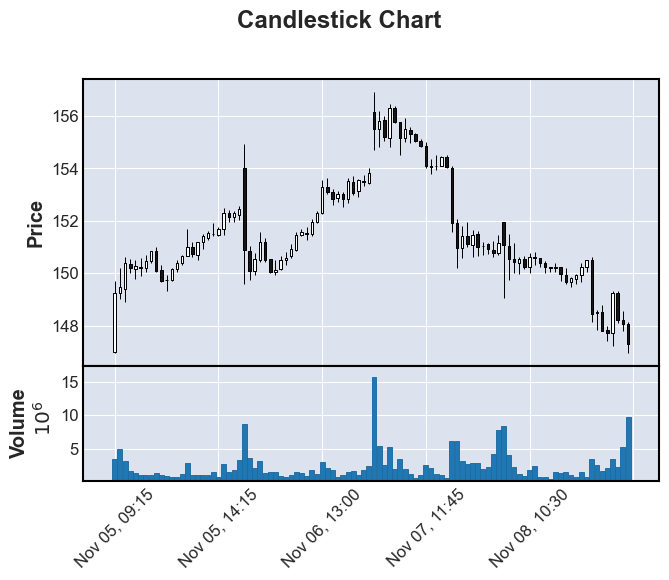

In [154]:
chart(data,'Candlestick Chart',True,swing_highs,swing_lows)